In [19]:
!pip install matplotlib
!pip install tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [20]:
dataset = tfds.builder('celeb_a')
dataset.download_and_prepare()

physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
data = dataset.as_dataset(shuffle_files=False)
data_train = data['train']
data_validation = data['validation']
data_test = data['test']


In [44]:
def preprocess(example, size = (64,64), mode = 'train'):
    image = example['image']
    print(image.shape)
    label = example['attributes']['Male']
    print(label)
    if mode == 'train':
        image_crop = tf.image.random_crop(image, size = (178, 178, 3))
        image_resized = tf.image.resize(image_crop, size = size)
        image_flip = tf.image.random_flip_left_right(image_resized)
        return (image_flip/255, tf.cast(label, tf.int32))
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, 0, 0, 178, 178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        print(image_resized/255.0, tf.cast(label, tf.int32))
        return (image_resized/255.0, tf.cast(label, tf.int32))
    
    

In [45]:
data_train  = data_train.take(50000)
data_validation = data_validation.take(1000)

BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(50000/BATCH_SIZE)


ds_train = data_train.map(
    lambda x: preprocess(x, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = data_validation.map(
    lambda x: preprocess(x, mode='validation'))
ds_valid = ds_valid.batch(BATCH_SIZE)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(218, 178, 3)
Tensor("args_20:0", shape=(), dtype=bool)
(218, 178, 3)
Tensor("args_20:0", shape=(), dtype=bool)
Tensor("truediv:0", shape=(64, 64, 3), dtype=float32) Tensor("Cast:0", shape=(), dtype=int32)


In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding = 'same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (1,1)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(64,(3, 3),padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (1,1)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (1,1)),
    tf.keras.layers.Conv2D(256,(3, 3),padding='same',activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation=None),
])

In [25]:
tf.random.set_seed(1)
model.compute_output_shape(input_shape=(None, 64, 64, 3))
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       7

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=1, steps_per_epoch=steps_per_epoch)

   2/1563 [..............................] - ETA: 1:43 - loss: 0.9791 - accuracy: 0.3594WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0519s vs `on_train_batch_end` time: 0.0808s). Check your callbacks.


1563/1563 [==============================] - 208s 133ms/step - loss: 0.5749 - accuracy: 0.6639 - val_loss: 0.4842 - val_accuracy: 0.7330


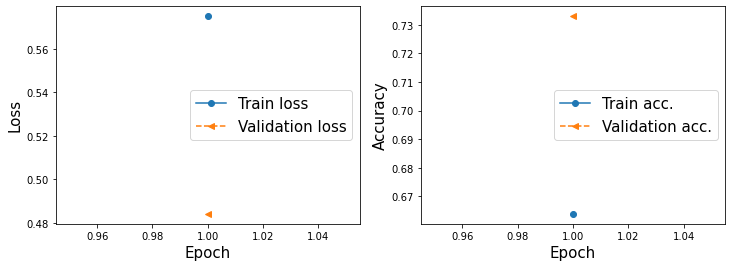

In [28]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_18.png', dpi=300)
plt.show()

In [39]:
ds_test = data_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(218, 178, 3)
Tensor("args_20:0", shape=(), dtype=bool)
Test Acc: 75.57%


<TakeDataset shapes: ((64, 64, 3), ()), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>
(<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.8657476 , 0.8461397 , 0.7716299 ],
        [0.893682  , 0.87407416, 0.7950664 ],
        [0.88502795, 0.8656145 , 0.7787569 ],
        ...,
        [0.5058824 , 0.3882353 , 0.15294118],
        [0.5045956 , 0.3882353 , 0.15294118],
        [0.5058824 , 0.38431373, 0.16078432]],

       [[0.8119121 , 0.7883827 , 0.73090726],
        [0.8081629 , 0.78592026, 0.7193149 ],
        [0.81872034, 0.79767156, 0.7269014 ],
        ...,
        [0.5058824 , 0.3882353 , 0.15294118],
        [0.5045956 , 0.3882353 , 0.15294118],
        [0.5058824 , 0.38431373, 0.16078432]],

       [[0.7962517 , 0.76487917, 0.7217419 ],
        [0.808701  , 0.77732843, 0.72751415],
        [0.81310415, 0.7817316 , 0.7307512 ],
        ...,
        [0.5058824 , 0.3882353 , 0.15294118],
        [0.50

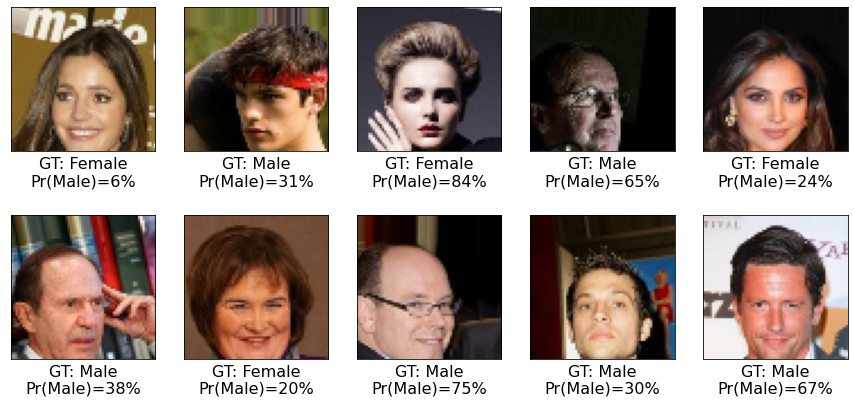

In [51]:
ds = ds_test.unbatch().take(10)
print(ds)

print(ds.batch(10))
pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    print(example)
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(Male)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)

In [53]:
for j,example in enumerate(ds):
    new = ds_test.concatenate(example)

TypeError: `dataset_or_iterator` must be a `tf.data.Dataset` or tf.data.Iterator object, but got <class 'tuple'>.

In [37]:


model.save('model.h5')
